In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import re
import seaborn as sns
from PIL import Image
from pathlib import Path
from IPython.display import clear_output

from metrics import gmsd, ssim, psnr

RAW_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/raw"
STACKREG_DIR = "/Users/farhanoktavian/imperial/thesis/sandbox/dataset/stackreg"
REG_TYPE = "ptv"

In [2]:
def read_image(img_dir):
    img = cv2.imread(str(img_dir), cv2.IMREAD_GRAYSCALE)
    return img

In [3]:
runs_txt = """HS001-Run04
    HS002-Run03
    HS005-Run08
    HS006-Run12
    HS007-Run04
    HS008-Run04
    HS009-Run06
    HS011-Run02
    HS012-Run04
    HS014-Run02
    HS015-Run03
    HS016-Run04
    HS017-Run02
    HS019-Run08
    HS020-Run06
    HS021-Run04
    HS022-Run04
    HS023-Run08
    HS025-Run04
    HS026-Run03
"""
run_tuples = [tuple(run.split("-")) for run in runs_txt.split()]

In [6]:
run_pairs = []
for sample_id, run_id in run_tuples:

    raw_sample_dir = Path(RAW_DIR) / sample_id
    regstack_sample_dir = Path(STACKREG_DIR) / sample_id

    raw_runs = sorted([x for x in raw_sample_dir.iterdir() if x.is_dir()])
    regstack_runs = sorted([x for x in regstack_sample_dir.iterdir() if x.is_dir()])

    for run in regstack_runs:
        run_id = run.name
        if run_id in [r.name for r in raw_runs]:
            run_pairs.append((sample_id, run_id, raw_sample_dir / run_id, run))

In [13]:
START_LAMBDA = 440
INTERVAL = 10

raw_metrics = {
    "gmsd": [],
    "ssim": [],
    "psnr": []
}

reg_metrics = {
    "gmsd": [],
    "ssim": [],
    "psnr": []
}

len_run_pairs = len(run_pairs)
for idx, tup in enumerate(run_pairs):
    clear_output(wait=True)
    print(f"{idx+1}/{len_run_pairs} runs")

    sample_id, run_id, a, b = tup

    raw_images = [read_image(x) for x in sorted(a.iterdir()) if x.suffix.lower() == ".png"]

    # Need to sort by number
    regstack_paths = sorted(b.iterdir(), key=lambda f: int(re.sub('\D', '', f.name)))
    regstack_images = [read_image(x) for x in regstack_paths if x.suffix.lower() == ".png"]

    raw_length = len(raw_images)
    reg_length = len(regstack_images)
    if raw_length > 29:
        length_skip = raw_length // 29
        raw_images = raw_images[::length_skip]
    if len(regstack_images) > 29:
        length_skip = reg_length // 29
        regstack_images = regstack_images[::length_skip]
    
    raw_gmsd = 0
    raw_ssim = 0
    raw_psnr = 0

    reg_gmsd = 0
    reg_ssim = 0
    reg_psnr = 0


    iter_count = 0
    for i in range(0,29,5):
        for j in range(0,29,5):
            if i == j:
                continue

            clear_output(wait=True)
            print(f"{i} and {j} channels")
            iter_count += 1

            raw_i = raw_images[i]
            raw_j = raw_images[j]

            reg_i = regstack_images[i]
            reg_j = regstack_images[j]

            raw_gmsd += gmsd(raw_i, raw_j)
            raw_ssim += ssim(raw_i, raw_j)
            raw_psnr += psnr(raw_i, raw_j)

            reg_gmsd += gmsd(reg_i, reg_j)
            reg_ssim += ssim(reg_i, reg_j)
            reg_psnr += psnr(reg_i, reg_j)
    
    raw_metrics["gmsd"].append(raw_gmsd / iter_count)
    raw_metrics["ssim"].append(raw_ssim / iter_count)
    raw_metrics["psnr"].append(raw_psnr / iter_count)

    reg_metrics["gmsd"].append(reg_gmsd / iter_count)
    reg_metrics["ssim"].append(reg_ssim / iter_count)
    reg_metrics["psnr"].append(reg_psnr / iter_count)

print("done")

25 and 20 channels
done


In [36]:
# df = pd.DataFrame({
#     "id": [f"{x[0]}-{x[1]}" for x in run_tuples],
#     "raw_gmsd": raw_metrics["gmsd"],
#     "raw_ssim": raw_metrics["ssim"],
#     "raw_psnr": raw_metrics["psnr"],
#     "reg_gmsd": reg_metrics["gmsd"],
#     "reg_ssim": reg_metrics["ssim"],
#     "reg_psnr": reg_metrics["psnr"]
# })

df = pd.DataFrame({
    "Id": [],
    "GMSD": [],
    "SSIM": [],
    "PSNR": [],
    "Type": []
})

for idx, tup in enumerate(run_tuples):
    samrun_id = f"{tup[0]}-{tup[1]}"

    df.loc[len(df)] = {
        "Id": samrun_id,
        "GMSD": raw_metrics["gmsd"][idx],
        "SSIM": raw_metrics["ssim"][idx],
        "PSNR": raw_metrics["psnr"][idx],
        "Type": "Raw"
    }

    df.loc[len(df)] = {
        "Id": samrun_id,
        "GMSD": reg_metrics["gmsd"][idx],
        "SSIM": reg_metrics["ssim"][idx],
        "PSNR": reg_metrics["psnr"][idx],
        "Type": "Registered"
    }

df.head()

,Id,GMSD,SSIM,PSNR,Type
0,HS001-Run04,0.086291,0.450478,13.240851,Raw
1,HS001-Run04,0.079421,0.473866,13.379825,Registered
2,HS002-Run03,0.136285,0.325794,10.479830,Raw
3,HS002-Run03,0.128411,0.363758,10.624484,Registered
4,HS005-Run08,0.088003,0.405009,15.350354,Raw


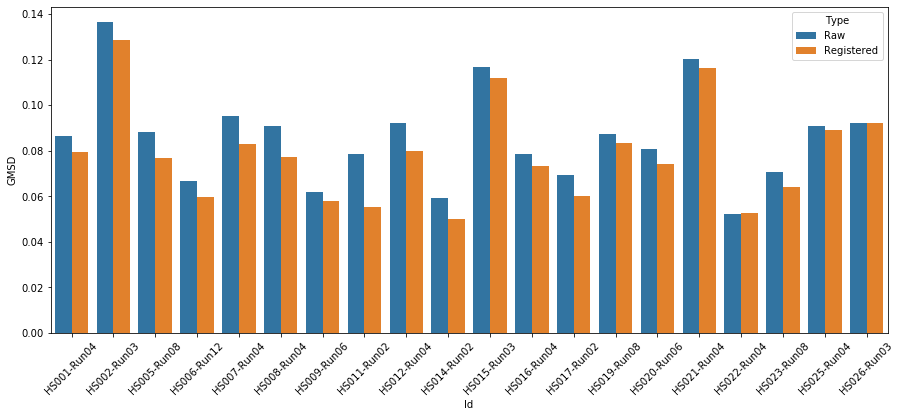

In [37]:
# GMSD raw vs reg
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=df, x="Id", y="GMSD", hue="Type", ax=ax)
plt.xticks(rotation=45)
plt.show()

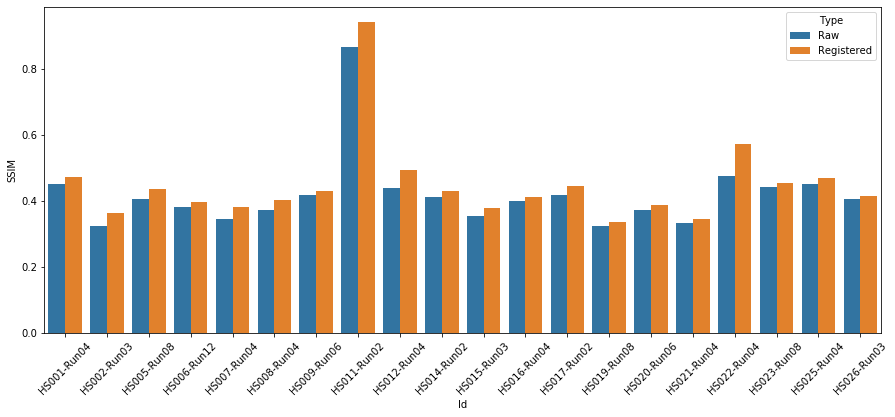

In [38]:
# SSIM raw vs reg
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=df, x="Id", y="SSIM", hue="Type", ax=ax)
plt.xticks(rotation=45)
plt.show()

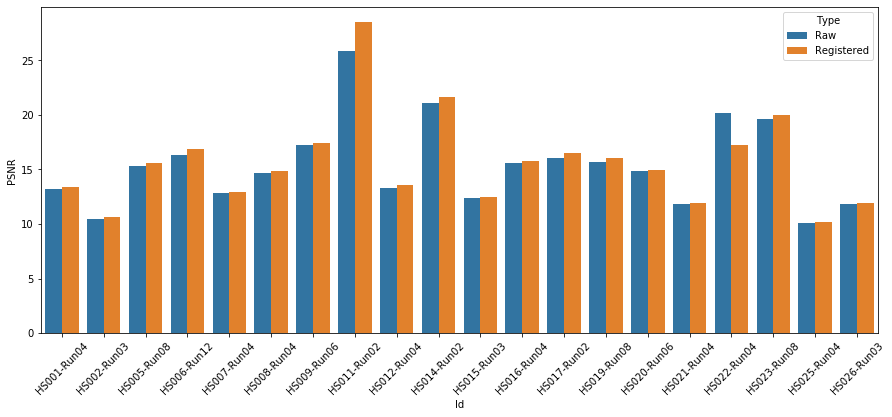

In [39]:
# PSNR raw vs reg
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=df, x="Id", y="PSNR", hue="Type", ax=ax)
plt.xticks(rotation=45)
plt.show()